# Testis Replicate 1 scRNA-Seq UMI Cutoff 2,000 and 5,000

This is the seurat analysis for testis replicate 1 after setting the UMI cuotff of 2,000

In [1]:
options(repr.plot.width=10, repr.plot.height=10)

In [2]:
DATA2k <- '../output/2018-03-21_explore_umi_testis1_2000.tsv'
DATA5k <- '../output/2018-03-21_explore_umi_testis1_5000.tsv'
OUTDIR2 <- '../output/testis1_scRNAseq_umi_2k_and_5k/2k'
OUTDIR5 <- '../output/testis1_scRNAseq_umi_2k_and_5k/5k'
REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')
NAME2k <- 'TestisUMI2k'
NAME5k <- 'TestisUMI5k'

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [3]:
source('../lib/seurat.R')

In [4]:
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
# 2k
dat <- read.table(DATA2k, header=TRUE)
sobj2 <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes = 200, project = NAME2k)
print(dim(sobj2@meta.data)[1])
# calculate the percent genes on chrom M
mask <- row.names(sobj2@raw.data) %in% mito
percent.mito <- Matrix::colSums(sobj2@raw.data[mask, ]/Matrix::colSums(sobj2@raw.data)) * 100
sobj2 <- AddMetaData(object = sobj2, metadata = percent.mito, col.name = "percent_mito")

[1] 1503


In [6]:
# 5k
dat <- read.table(DATA5k, header=TRUE)
sobj5 <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes = 200, project = NAME5k)
print(dim(sobj5@meta.data)[1])
# calculate the percent genes on chrom M
mask <- row.names(sobj5@raw.data) %in% mito
percent.mito <- Matrix::colSums(sobj5@raw.data[mask, ]/Matrix::colSums(sobj5@raw.data)) * 100
sobj5 <- AddMetaData(object = sobj5, metadata = percent.mito, col.name = "percent_mito")

[1] 723


In [7]:
# Filter cells based on low and high gene counts
sobj2 <- FilterCells(object=sobj2, subset.names=c("nGene"), low.thresholds=c(200), high.thresholds=c(6000))
sobj5 <- FilterCells(object=sobj5, subset.names=c("nGene"), low.thresholds=c(200), high.thresholds=c(6000))

In [8]:
print(dim(sobj2@meta.data)[1])
print(dim(sobj5@meta.data)[1])

[1] 1497
[1] 717


In [9]:
sobj2 <- NormalizeData(object = sobj2, normalization.method = "LogNormalize", scale.factor = 1e4)
sobj2 <- FindVariableGenes(object = sobj2, mean.function = ExpMean, dispersion.function = LogVMR,
                           x.low.cutoff = 0.01, 
                           x.high.cutoff = 2.8, 
                           y.cutoff = 0.5,
                           y.high.cutoff = Inf,
                           do.plot=FALSE
                          )

In [10]:
sobj5 <- NormalizeData(object = sobj5, normalization.method = "LogNormalize", scale.factor = 1e4)
sobj5 <- FindVariableGenes(object = sobj5, mean.function = ExpMean, dispersion.function = LogVMR,
                           x.low.cutoff = 0.01, 
                           x.high.cutoff = 2.8, 
                           y.cutoff = 0.5,
                           y.high.cutoff = Inf,
                           do.plot=FALSE
                          )

In [11]:
var.genes2 = sobj2@var.genes
var.genes5 = sobj5@var.genes

In [12]:
print(length(x = var.genes2))
print(length(x = var.genes5))

[1] 3269
[1] 2603


In [13]:
var.genes = intersect(var.genes2, var.genes5)

In [14]:
length(var.genes)

[1] 1970

In [15]:
sobj2 <- ScaleData(object = sobj2, vars.to.regress = c("nUMI"), display.progress = F)
sobj2 <- RunPCA(object = sobj2, pc.genes = var.genes, do.print = FALSE, pcs.compute = 100)
sobj2 <- ProjectPCA(object = sobj2, do.print = F)

In [16]:
sobj5 <- ScaleData(object = sobj5, vars.to.regress = c("nUMI"), display.progress = F)
sobj5 <- RunPCA(object = sobj5, pc.genes = var.genes, do.print = FALSE, pcs.compute = 100)
sobj5 <- ProjectPCA(object = sobj5, do.print = F)

In [17]:
sobj2 <- FindClusters(object = sobj2, reduction.type = "pca", dims.use = 1:30, resolution = c(0.6, 1.2), print.output = F, save.SNN = TRUE, force.recalc=T)
sobj5 <- FindClusters(object = sobj5, reduction.type = "pca", dims.use = 1:30, resolution = c(0.6, 1.2), print.output = F, save.SNN = TRUE, force.recalc=T)

In [18]:
sobj2 <- RunTSNE(object = sobj2, dims.use = 1:30, do.fast = TRUE)
sobj5 <- RunTSNE(object = sobj5, dims.use = 1:30, do.fast = TRUE)

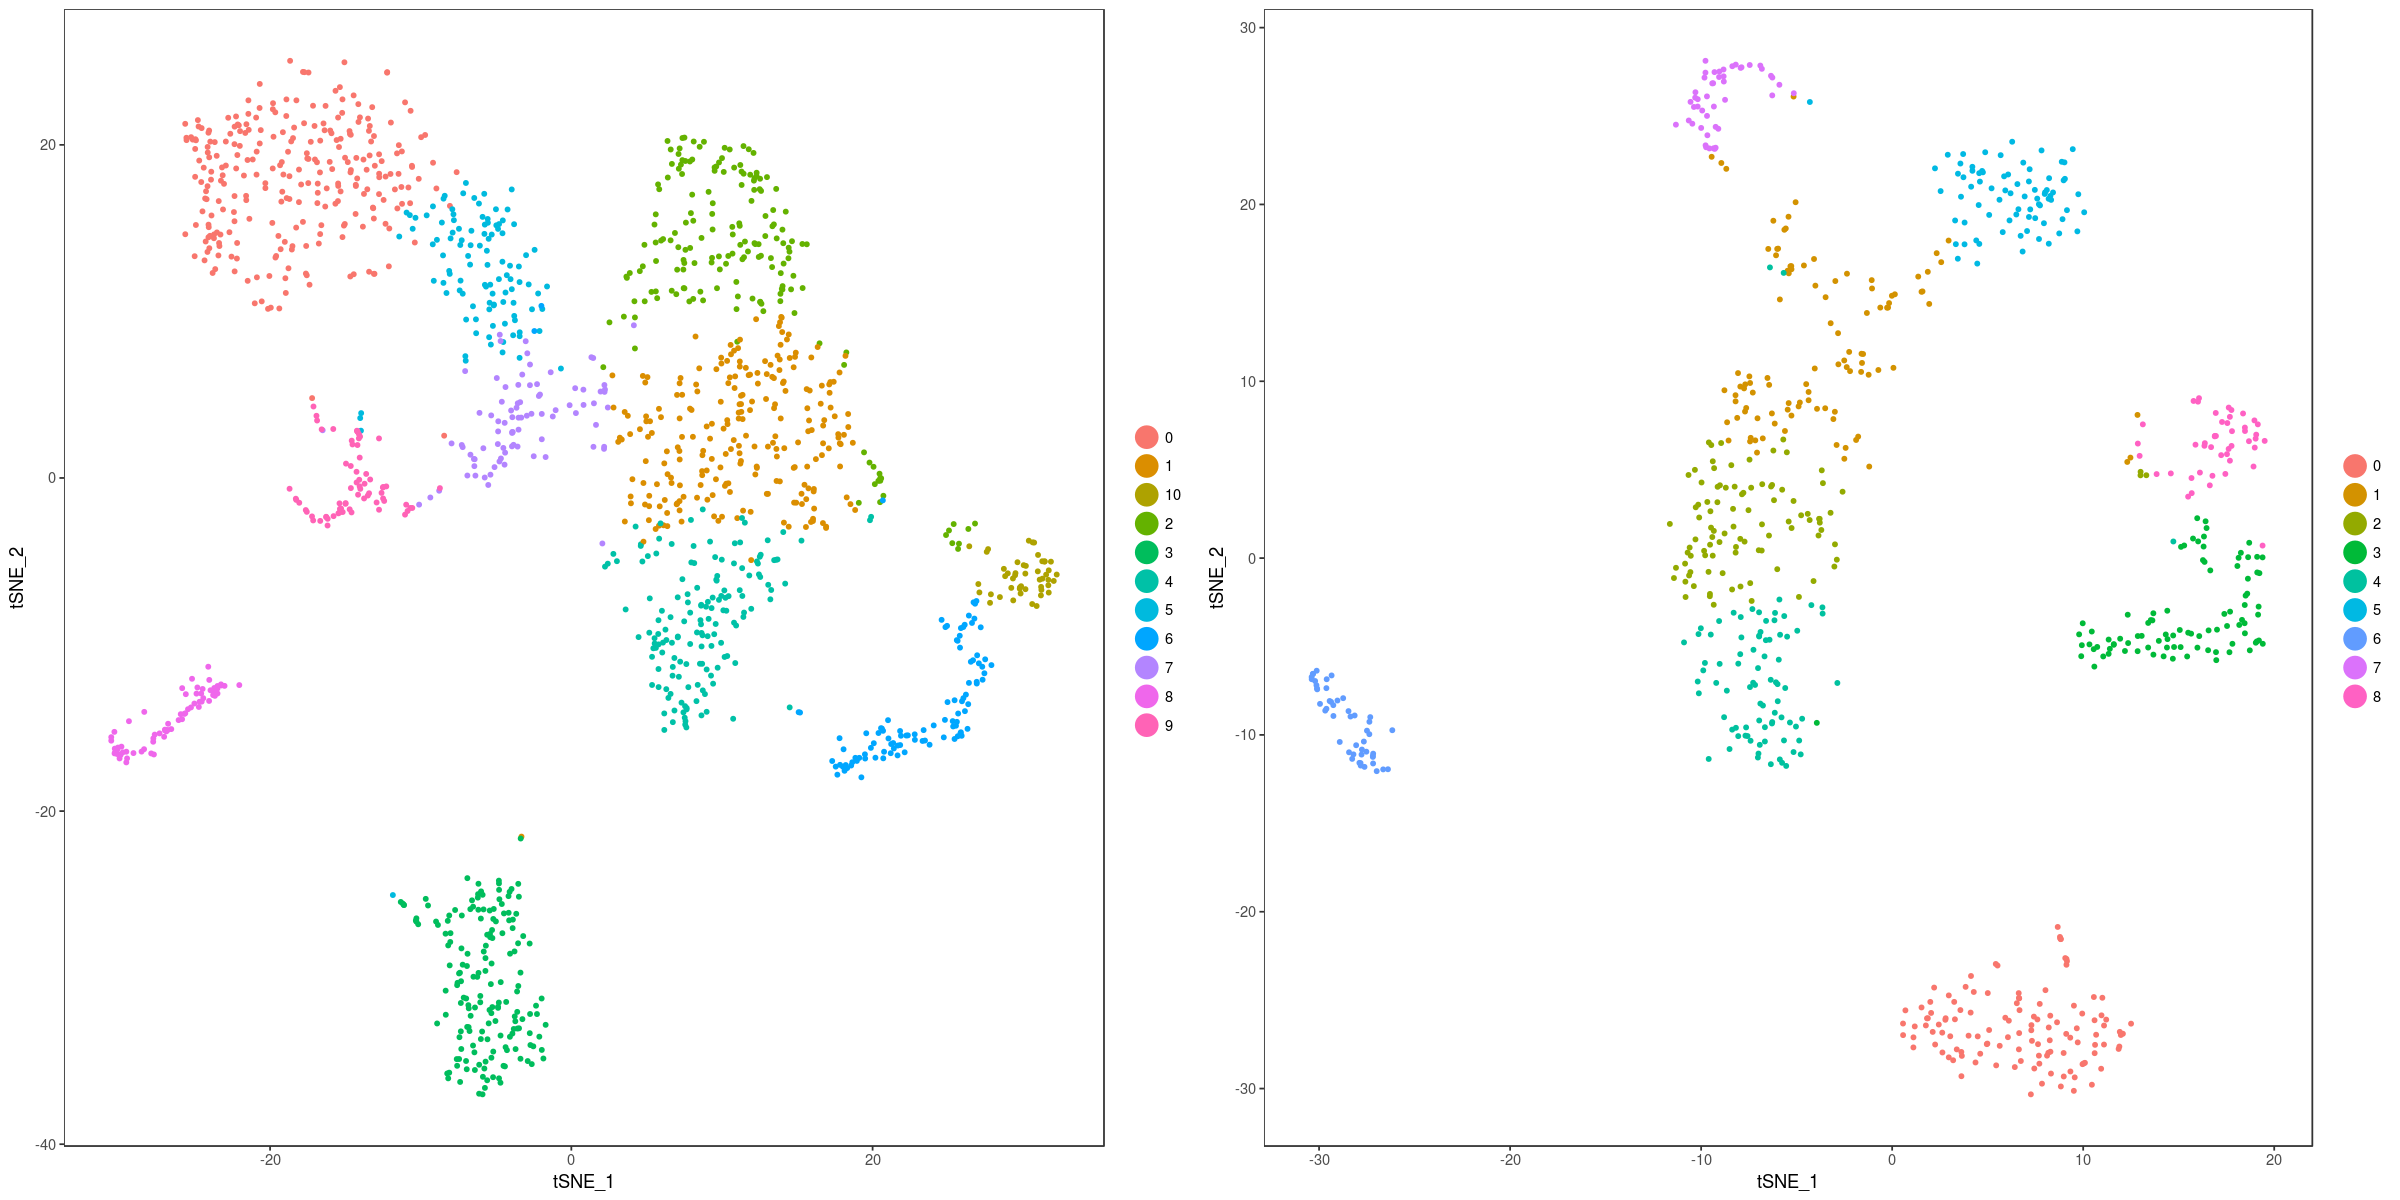

In [19]:
p2 <- TSNEPlot(object = sobj2, group.by='res.1.2', do.return = T)
p5 <- TSNEPlot(object = sobj5, group.by='res.1.2', do.return = T)
options(repr.plot.width=20, repr.plot.height=10)
plot_grid(p2, p5)

In [20]:
dump_seurat(object = sobj2, dir = OUTDIR2)
dump_seurat(object = sobj5, dir = OUTDIR5)

In [21]:
# Save cluster info
params <- c(0.6, 1.2)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    sobj2 <- SetAllIdent(sobj2, id = name)
    markers <- FindAllMarkers(object = sobj2, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR2, fname = fname)
}

In [22]:
# Save cluster info
params <- c(0.6, 1.2)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    sobj5 <- SetAllIdent(sobj5, id = name)
    markers <- FindAllMarkers(object = sobj5, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR5, fname = fname)
}